#### Implementation of Faster R-CNN from scratch using PyTorch

Most of the state-of-the-art models are build on top of groundwork laid by Faster R-CNN model. Faster R-CNN is an object detection model that identifies objects in an image and draws bounding boxes around them, while also classifying the objects. It’s a two-stage detector:
1. Stage 1: Proposes potential regions in the image that might contain objects. This is handled by the Region Proposal Network (RPN).
2. Stage 2: Uses these proposed regions to predict the class of the object and refines the bounding box to better match the object.

Look at image below to understand the architecture of Faster R-CNN:
![Faster R-CNN Architecture](./faster_rcnn_architecture.png)

#### Stage 1: Region Proposal Network (RPN)

Backbone Network:
- The image passes through a convolution neural network (CNN) like ResNet or VGG
- This extracts feature maps from the image, which are then used to identify regions of interest (RoIs).

Anchors:
- Anchors are boxes of different sizes and shapes placed over points in the feature map.
- Each anchor box represents a possible object location
- At every point on the feature map, anchor boxes are generated with different sizes and aspect ratios.

Classification of Anchors:
- The RPN predicts whether each anchor box is background (no object) or foreground (contains an object).
- Positive (foreground) anchors: Boxes with high overlap with actual objects.
- Negative (background) anchors: Boxes with little or no overlap with objects.

Bounding Box Refinement:
- The RPN also refines the anchor boxes to better align them with the actual objects by predicting offsets (adjustments).

Loss Function:
- Classification Loss: Helps the model decide if the anchor is background or foreground.
- Regression loss: Helps adjust the anchor boxes to fit the objects more precisely.

#### Stage 2: Object Detection and Box Refinement

Region Proposal:
- After RPN, we get region proposals (RoIs) (refined boxes that likely contain objects).

RoI Pooling:
- The region proposals have different sizes, but the neural network needs fixed-size inputs.
- ROI Pooling resizes all region proposals to a fixed size by dividing them into smaller regions and applying pooling, making them uniform.

Object Classification:
- Each region proposal is passed through a small network to predict the category (e.g., dog, car, etc.) of the object inside it.
- Cross-entropy loss is used to classify the objects into categories.

Bounding Box Refinement (Again):
- The region proposals are refined again to better match the actual objects, using offsets.
- This uses regression loss to adjust the proposals.

Multi-task Learning
- The network in stage 2 learns both to predict object categories and refine bounding boxes at the same time.

#### Training

Two ways to train:
1. Train in stages: First, train the region proposal network (RPN) and then the classifier and regressor.
2. Train together: Train both stages at the same time (faster and more efficient).

##### Let's implement and Fine-Tune Faster R-CNN in PyTorch

Firstly, we will import the necessary libraries and set up the environment. We will use PyTorch and torchvision for this implementation. Make sure you have them installed in your Python environment.

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

##### Load Pre-trained Faster R-CNN Model

In [46]:
# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Number of classes (your dataset classes + 1 for background)
num_classes = 21  # Example: 2 classes + 1 background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model with a new one (for the number of classes in your dataset)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

##### Prepare the Dataset
- Faster R-CNN requires images and corresponding annotations (bounding boxes and labels).
- Your dataset should return: Images and Target dictionaries that include bounding boxes (boxes) and labels (labels).


In [48]:
import torch
import os
import cv2
from xml.etree import ElementTree
from torch.utils.data import Dataset


def load_pascal_voc_dataset(dataset_path: str, split: str = 'train'):
    """
    Load PASCAL VOC dataset

    Args:
        dataset_path: Path to VOC dataset (e.g., '/path/to/VOCdevkit/VOC2012')
        split: 'train', 'val', or 'test'

    Returns:
        images, boxes, labels
    """

    # VOC class names
    classes = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
               "bus", "car", "cat", "chair", "cow", "diningtable", "dog",
               "horse", "motorbike", "person", "pottedplant", "sheep",
               "sofa", "train", "tvmonitor"]

    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    # Paths
    image_dir = os.path.join(dataset_path, "JPEGImages")
    annotation_dir = os.path.join(dataset_path, "Annotations")
    split_file = os.path.join(dataset_path, "ImageSets", "Main", f"{split}.txt")

    if not os.path.exists(split_file):
        print(f"Split file not found: {split_file}")
        return [], [], []

    # Read image IDs
    with open(split_file, "r") as f:
        image_ids = [line.strip() for line in f.readlines()]

    images = []
    all_boxes = []
    all_labels = []

    for img_id in image_ids:
        # Load image
        img_path = os.path.join(image_dir, f"{img_id}.jpg")
        if not os.path.exists(img_path):
            continue

        image = cv2.imread(img_path)
        if image is None:
            continue

        # Load annotation
        ann_path = os.path.join(annotation_dir, f"{img_id}.xml")
        if not os.path.exists(ann_path):
            continue

        tree = ElementTree.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            # Get class name
            class_name = obj.find("name").text
            if class_name not in class_to_idx:
                continue

            # Get bounding box
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Convert to (x, y, w, h) format
            w = xmax - xmin
            h = ymax - ymin

            boxes.append((xmin, ymin, xmax, ymax))
            labels.append(class_to_idx[class_name])

        if len(boxes) > 0:  # Only add images with annotations
            images.append(image)
            all_boxes.append(boxes)
            all_labels.append(labels)

    print(f"Loaded {len(images)} images from {split} split")
    return images, all_boxes, all_labels

In [49]:
class VOCDataset(Dataset):
    def __init__(self, path_dataset: str, split: str = "train", dataset_transform=None):
        self.path_dataset = path_dataset
        self.split = split
        self.images, self.boxes, self.labels = load_pascal_voc_dataset(path_dataset, split)
        self.dataset_transform = dataset_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        boxes = self.boxes[idx]
        labels = self.labels[idx]

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.dataset_transform:
            # should have to tensor and normalize
            image = self.dataset_transform(image)

        return image, target

In [50]:
from torchvision import transforms

path = "/Users/hinsun/Workspace/ComputerScience/DeepLearning/data/VOCdevkit/VOC2012"

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create the dataset
voc_dataset = VOCDataset(
    path_dataset=path,
    split="train",
    dataset_transform=transform
)

Loaded 5717 images from train split


In [19]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# same with load_pascal_voc_dataset
voc_classes = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]


def show_sample(image, boxes, labels):
    plt.imshow(image)
    plt.axis("off")

    for box, label in zip(boxes, labels):
        x1, y1, w, h = box
        rect = patches.Rectangle(
            (x1, y1), w, h, linewidth=2, edgecolor="red", facecolor="none"
        )
        plt.gca().add_patch(rect)
        plt.text(
            x1,
            y1 - 5,
            voc_classes[label],
            color="white",
            fontsize=12,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


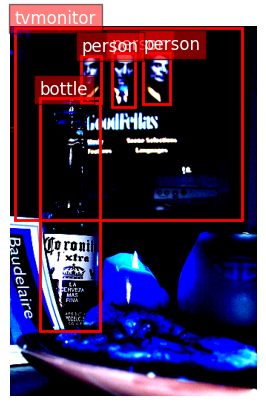

In [36]:
sample = voc_dataset[3]

[image, target] = sample

# image.shape -> torch.Size([3, 375, 500], dtype=torch.float32)
# convert to numpy array for visualization
image = image.permute(1, 2, 0).numpy()

show_sample(image, target["boxes"], target["labels"])

##### Set Up Data Loader

In [54]:
# Split into train and validation sets
indices = torch.randperm(len(voc_dataset)).tolist()

num_train = int(0.8 * len(voc_dataset))

val_dataset = torch.utils.data.Subset(voc_dataset, indices[num_train:])
train_dataset = torch.utils.data.Subset(voc_dataset, indices[:num_train])

# Create data loaders
batch_size_train = 4
batch_size_val = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size_train,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size_val,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

##### Set Up Training Loop

In [56]:
# device = torch.accelerator.current_accelerator()
device = "cpu"
model.to(device)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# train model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Training loop
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()
        running_loss += losses.item()

    # Update the learning rate
    lr_scheduler.step()
    print(f'Epoch: {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print("Training complete!")

KeyboardInterrupt: 